# Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

2024-07-30 22:46:19.062976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Laden

In [2]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

# Data Preparation

In [3]:
asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1.fillna(0)
df = df.drop(["TUFINLWGT", "TUCASEID"], axis=1)

print(df.shape)
df.head()

(21361, 461)


,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,TEMJOT,TRDPFTPT,...,t119999,t130115,t130123,t130399,t130402,t150899,t019999,t060402,t090302,t180599
3,8,31,2,40,1,2,2,1,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1,59,2,39,1,2,1,1,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1,35,1,43,1,2,2,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,5,54,2,44,1,2,1,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-1,40,2,43,1,2,2,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022.fillna(0)
df2022 = df2022.drop(["TUFINLWGT", "TUCASEID"], axis=1)

print(df2022.shape)
df2022.head()

(4226, 399)


,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,TEMJOT,TRDPFTPT,...,t181599,t181601,t181801,t181899,t189999,t500101,t500103,t500105,t500106,t500107
1,-1,30,2,39,1,2,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
7,6,58,2,39,1,2,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
8,-1,62,2,39,1,2,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
10,-1,45,2,39,1,2,2,1,2,1,...,0,0,0,0,0,0,0,0,0,0
15,4,42,1,39,1,2,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# One-Hot Encoding
one_hot_vars = ['TESEX', 'PTDTRACE', 'PEHSPNON', 'GTMETSTA', 'TELFS', 'TEMJOT', 'TRDPFTPT', 'TESCHENR', 'TESCHLVL', 'TRSPPRES', 'TESPEMPNOT', 'TRSPFTPT']
df_encoded = pd.get_dummies(df, columns=one_hot_vars)

# Label Encoding
label_encoder = LabelEncoder()
df_encoded['PEEDUCA'] = label_encoder.fit_transform(df['PEEDUCA'])
df_encoded.head()

,TRYHHCHILD,TEAGE,PEEDUCA,TRERNWA,TRCHILDNUM,TEHRUSLT,TUDIARYDAY,TRHOLIDAY,TRTEC,TRTHH,...,TRSPPRES_1,TRSPPRES_2,TRSPPRES_3,TESPEMPNOT_-1,TESPEMPNOT_1,TESPEMPNOT_2,TRSPFTPT_-1,TRSPFTPT_1,TRSPFTPT_2,TRSPFTPT_3
3,8,31,9,469.44,3,32,1,0,-1,705,...,False,False,True,True,False,False,True,False,False,False
4,-1,59,8,302.50,0,12,1,0,-1,0,...,True,False,False,False,False,True,True,False,False,False
10,1,35,12,1538.46,2,55,1,0,-1,254,...,True,False,False,False,True,False,False,True,False,False
11,5,54,13,1211.53,2,38,6,0,-1,125,...,False,True,False,False,False,True,True,False,False,False
12,-1,40,12,961.53,0,40,7,0,-1,0,...,False,False,True,True,False,False,True,False,False,False


In [6]:
encoded2022 = pd.get_dummies(df2022, columns=one_hot_vars)
encoded2022['PEEDUCA'] = label_encoder.fit_transform(df2022['PEEDUCA'])

encoded2022.head()

,TRYHHCHILD,TEAGE,PEEDUCA,TRERNWA,TRCHILDNUM,TEHRUSLT,TUDIARYDAY,TRHOLIDAY,TRTEC,TRTHH,...,TRSPPRES_1,TRSPPRES_2,TRSPPRES_3,TESPEMPNOT_-1,TESPEMPNOT_1,TESPEMPNOT_2,TRSPFTPT_-1,TRSPFTPT_1,TRSPFTPT_2,TRSPFTPT_3
1,-1,30,8,640.00,0,40,5,0,-1,0,...,True,False,False,False,True,False,False,True,False,False
7,6,58,8,1750.00,1,55,1,0,-1,580,...,False,False,True,True,False,False,True,False,False,False
8,-1,62,8,769.23,0,40,1,0,-1,0,...,True,False,False,False,True,False,False,True,False,False
10,-1,45,8,520.00,0,40,1,0,-1,0,...,True,False,False,False,True,False,False,False,True,False
15,4,42,8,1615.38,1,50,7,0,-1,85,...,False,True,False,False,False,True,True,False,False,False


In [7]:
kolommen_df1 = set(df.columns)
kolommen_df2 = set(df2022.columns)

ontbrekende_in_df1 = kolommen_df2 - kolommen_df1
ontbrekende_in_df2 = kolommen_df1 - kolommen_df2

print("Ontbrekende kolommen in df1:", ontbrekende_in_df1)
print("Ontbrekende kolommen in df2:", ontbrekende_in_df2)

for kolom in ontbrekende_in_df1:
    df[kolom] = 0

for kolom in ontbrekende_in_df2:
    df2022[kolom] = 0

print(df.shape)
print(df2022.shape)

# Juiste volgorde
alle_kolommen = sorted(list(kolommen_df1 | kolommen_df2))
df = df[alle_kolommen]
df2022 = df2022[alle_kolommen]

Ontbrekende kolommen in df1: {'t090499', 't070299', 't130111'}
Ontbrekende kolommen in df2: {'t080102', 't049999', 't130214', 't180399', 't050404', 't130209', 't130401', 't130229', 't150599', 't181099', 't060104', 't100401', 't181699', 't110299', 't060402', 't180199', 't119999', 't080299', 't020599', 't130231', 't010199', 't050203', 't130205', 't060299', 't150899', 't130115', 't010501', 't060403', 't020999', 't040399', 't100299', 't050405', 't080302', 't090199', 't080399', 't180499', 't070301', 't130217', 't090402', 't070199', 't130215', 't180604', 't180799', 't130123', 't100305', 't020299', 't079999', 't070399', 't130402', 't129999', 't130212', 't039999', 't130399', 't169999', 't100399', 't060204', 't150799', 't060303', 't050299', 't080602', 't080801', 't109999', 't181499', 't130135', 't130222'}
(21361, 464)
(4226, 464)


/var/folders/wq/9k50k0z17hj5h7vgt_4rdbwh0000gn/T/ipykernel_82981/3644154621.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[kolom] = 0
/var/folders/wq/9k50k0z17hj5h7vgt_4rdbwh0000gn/T/ipykernel_82981/3644154621.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[kolom] = 0
/var/folders/wq/9k50k0z17hj5h7vgt_4rdbwh0000gn/T/ipykernel_82981/3644154621.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [8]:
kolommen_df1 = set(df_encoded.columns)
kolommen_df2 = set(encoded2022.columns)

ontbrekende_in_df1 = kolommen_df2 - kolommen_df1
ontbrekende_in_df2 = kolommen_df1 - kolommen_df2

print("Ontbrekende kolommen in df1:", ontbrekende_in_df1)
print("Ontbrekende kolommen in df2:", ontbrekende_in_df2)

for kolom in ontbrekende_in_df1:
    df_encoded[kolom] = 0

for kolom in ontbrekende_in_df2:
    encoded2022[kolom] = 0

print(df_encoded.shape)
print(encoded2022.shape)

# Juiste volgorde
alle_kolommen = sorted(list(kolommen_df1 | kolommen_df2))
df_encoded = df_encoded[alle_kolommen]
encoded2022 = encoded2022[alle_kolommen]

Ontbrekende kolommen in df1: {'t090499', 't070299', 't130111'}
Ontbrekende kolommen in df2: {'PTDTRACE_21', 't080102', 't049999', 't130214', 't180399', 't050404', 't130209', 't130401', 'PTDTRACE_18', 't130229', 't150599', 't181099', 't060104', 't100401', 't181699', 't110299', 'PTDTRACE_19', 't060402', 't180199', 't119999', 't080299', 't020599', 't130231', 't010199', 't050203', 't130205', 't060299', 't150899', 't130115', 't010501', 't060403', 't020999', 't040399', 't100299', 't050405', 't080302', 't090199', 't080399', 't180499', 'PTDTRACE_12', 't070301', 't130217', 't090402', 't070199', 't130215', 't180604', 't180799', 't130123', 't100305', 't020299', 't079999', 'PTDTRACE_15', 't070399', 't130402', 't129999', 't130212', 't039999', 't130399', 't169999', 't100399', 't060204', 't150799', 't060303', 't050299', 't080602', 't080801', 't109999', 't181499', 't130135', 't130222'}
(21361, 499)
(4226, 499)


In [9]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

train_set, test_set = train_test_split(df_encoded, test_size=0.2, random_state=10)

X_train_encoded = train_set.drop("TRERNWA", axis=1)
y_train_encoded = train_set["TRERNWA"]
X_test_encoded = test_set.drop("TRERNWA", axis=1)
y_test_encoded = test_set["TRERNWA"]

In [10]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

X_encoded2022 = encoded2022.drop("TRERNWA", axis=1)
y_encoded2022 = encoded2022["TRERNWA"]

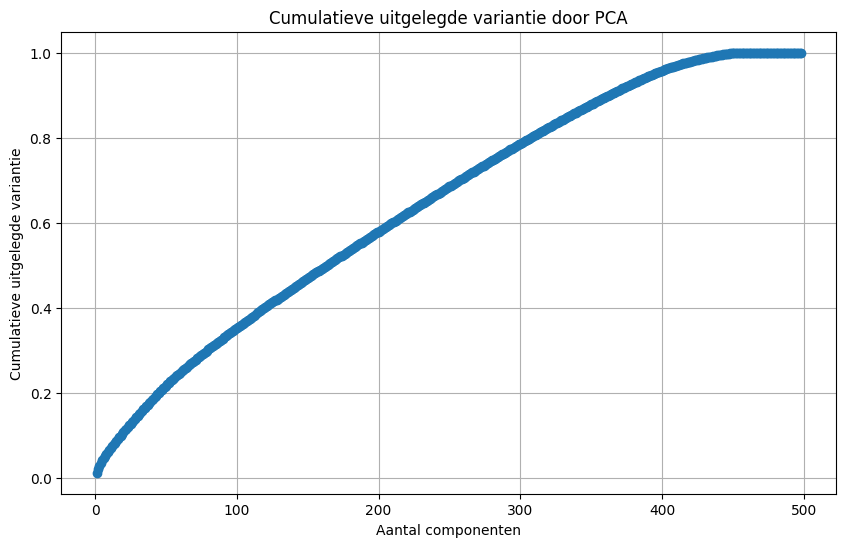

Aantal componenten dat 95% van de variantie verklaart: 395
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.841928 -0.048316  0.425237  0.471229 -0.095138 -0.084776 -0.585923   
1  1.873239 -1.032810  1.750154 -1.427273  0.444550 -0.419925 -0.202666   
2 -1.291143 -1.405237  2.179005  2.778459 -1.402978 -0.894640 -0.526054   
3 -1.493687 -0.722042  0.419187  1.213886  0.205671 -0.772034  1.879911   
4 -1.863952  0.200045 -2.365881 -1.446015  2.799150  0.434373 -0.531538   

        PC8       PC9      PC10  ...     PC387     PC388     PC389     PC390  \
0 -0.691502 -0.898584  1.120437  ...  0.823054 -0.362344  0.380970  0.015538   
1  0.195496 -2.357339  0.002640  ...  0.195116  0.172638 -0.582502 -0.202078   
2  0.003919 -1.286323  1.300411  ...  0.660238  0.097961  0.789217  0.034447   
3  1.583530  0.303263  1.371199  ...  0.658671  0.063303  0.939048  0.171617   
4  2.009902  0.152796 -0.671131  ... -0.985117 -2.323070  4.377444 -0.798351   

      PC3

In [11]:
target_column = 'TRERNWA'
df_target = df_encoded[target_column]
df_features = df_encoded.drop(columns=[target_column])

df2022_target = encoded2022[target_column]
df2022_features = encoded2022.drop(columns=[target_column])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

df2022_scaled = scaler.transform(df2022_features)

pca = PCA()
principal_components = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_cumsum = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_cumsum) + 1), explained_variance_cumsum, marker='o', linestyle='--')
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatieve uitgelegde variantie')
plt.title('Cumulatieve uitgelegde variantie door PCA')
plt.grid()
plt.show()

n_components = next(i for i, total_var in enumerate(explained_variance_cumsum) if total_var > 0.95) + 1
print(f'Aantal componenten dat 95% van de variantie verklaart: {n_components}')

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

df2022_pca = pca.transform(df2022_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca_df = pd.DataFrame(data=df_pca, columns=pca_columns)
df2022_pca_df = pd.DataFrame(data=df2022_pca, columns=pca_columns)

df_with_pca = pd.concat([df_pca_df, df_target.reset_index(drop=True)], axis=1)
df2022_with_pca = pd.concat([df2022_pca_df, df2022_target.reset_index(drop=True)], axis=1)

print(df2022_with_pca.head())

In [12]:
train_set, test_set = train_test_split(df_with_pca, test_size=0.2, random_state=10)

X_train_pca = train_set.drop("TRERNWA", axis=1)
y_train_pca = train_set["TRERNWA"]
X_test_pca = test_set.drop("TRERNWA", axis=1)
y_test_pca = test_set["TRERNWA"]

X_pca2022 = df2022_with_pca.drop("TRERNWA", axis=1)
y_pca2022 = df2022_with_pca["TRERNWA"]

# Modellen

## Klassieke Statistische Modellen

### Lineaire Regressie


Test MAE: 105555530850428.11
R2 Score: -3.280733543750079e+25
______

2022 MAE: 974294483457315.0
2022 R2 Score: -1.534113519034174e+27



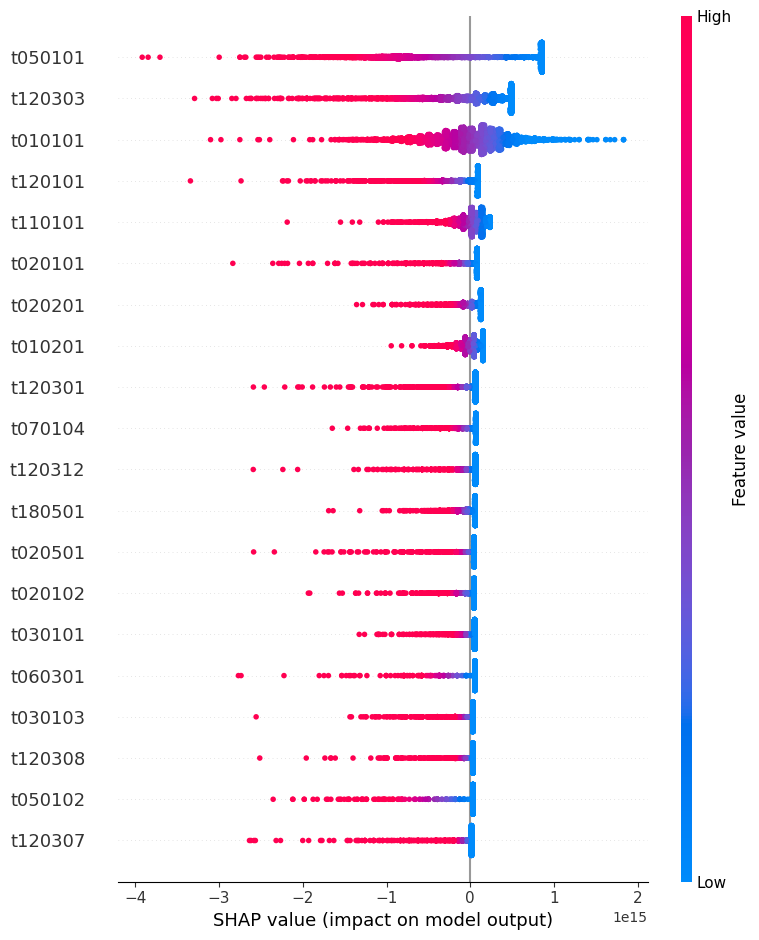

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Encoded


Test MAE: 36641069580014.97
R2 Score: -2.98473530339552e+24
______

2022 MAE: 1096053660717134.5
2022 R2 Score: -2.518534893224892e+27



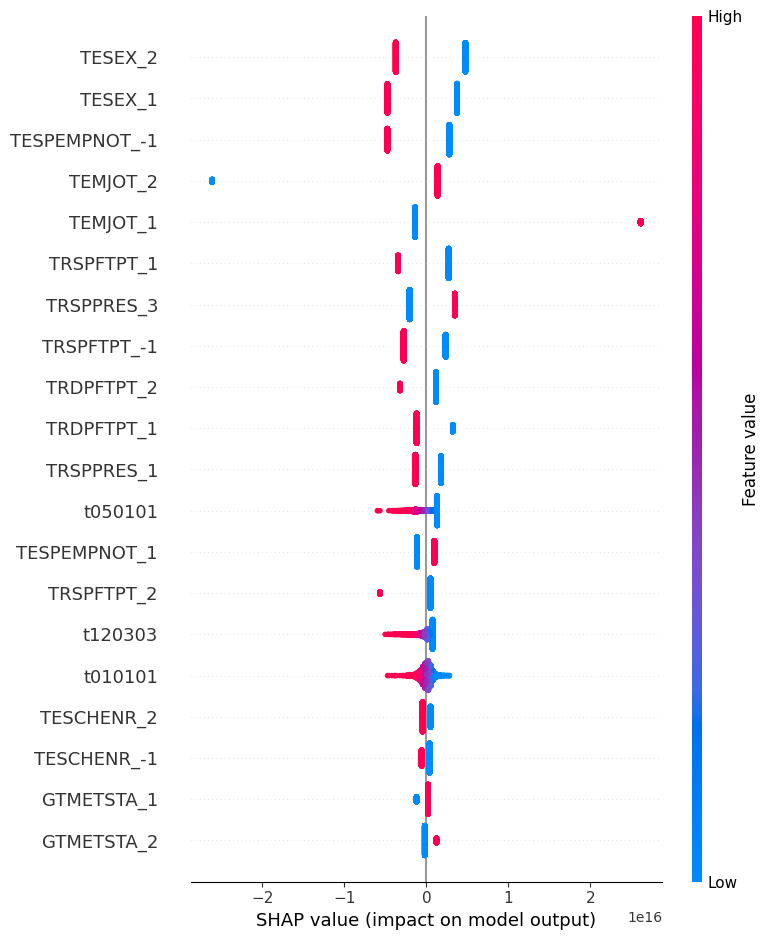

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train_encoded)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA


Test MAE: 476.35192660809986
R2 Score: -1.1674991171592564
______

2022 MAE: 507.50169826540827
2022 R2 Score: -0.032145125816977815



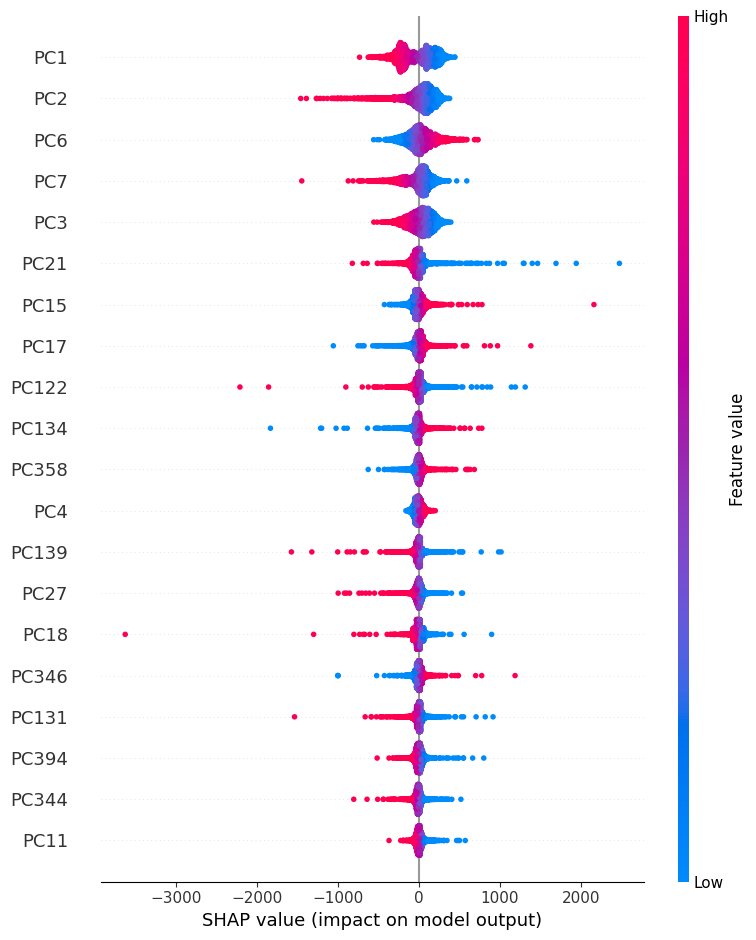

In [12]:
model = LinearRegression()
model.fit(X_train_pca, y_train_pca)

y_pred = model.predict(X_test_pca)
y_pred2022 = model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_pca)

shap_values_test = explainer.shap_values(X_test_pca)

shap.summary_plot(shap_values_test, X_test_pca, feature_names=X_train_pca.columns)

plt.show()

### Ridge Regressie

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 439.449078691571
R2 Score: 0.4040867087396931
______

2022 MAE: 499.17417124551787
2022 R2 Score: -0.02012627858544036



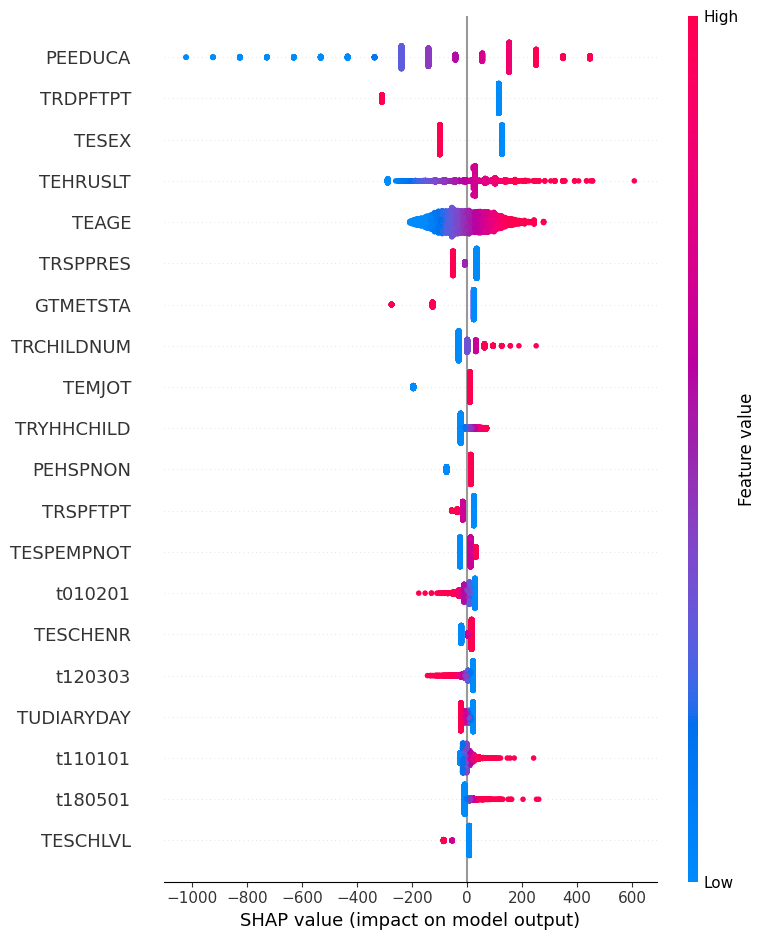

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Encoded

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 435.2559684796811
R2 Score: 0.4131513766358643
______

2022 MAE: 497.4740946107674
2022 R2 Score: -0.008577819920962737



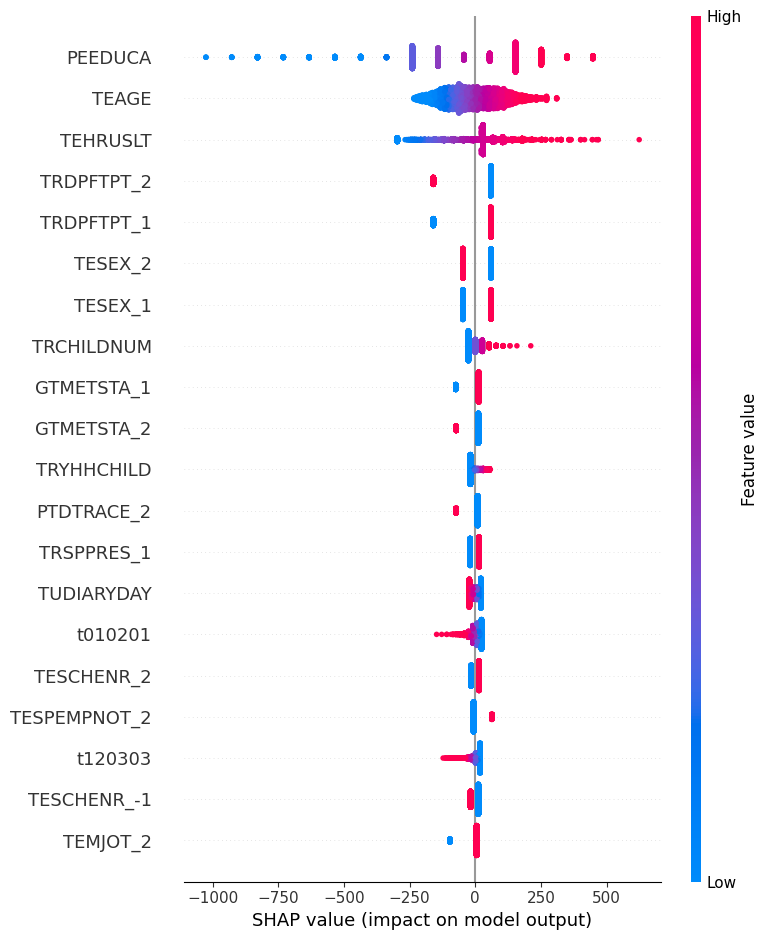

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA

In [13]:
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_pca, y_train_pca)

y_pred = best_ridge_model.predict(X_test_pca)
y_pred2022 = best_ridge_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 462.6380039936783
R2 Score: 0.0030234797251051937
______

2022 MAE: 507.3009238606023
2022 R2 Score: -0.03678621521900771



### Lasso Regressie

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 435.4911139110048
R2 Score: 0.42317941715945717
______

2022 MAE: 485.91740241693566
2022 R2 Score: 0.35400644537323345



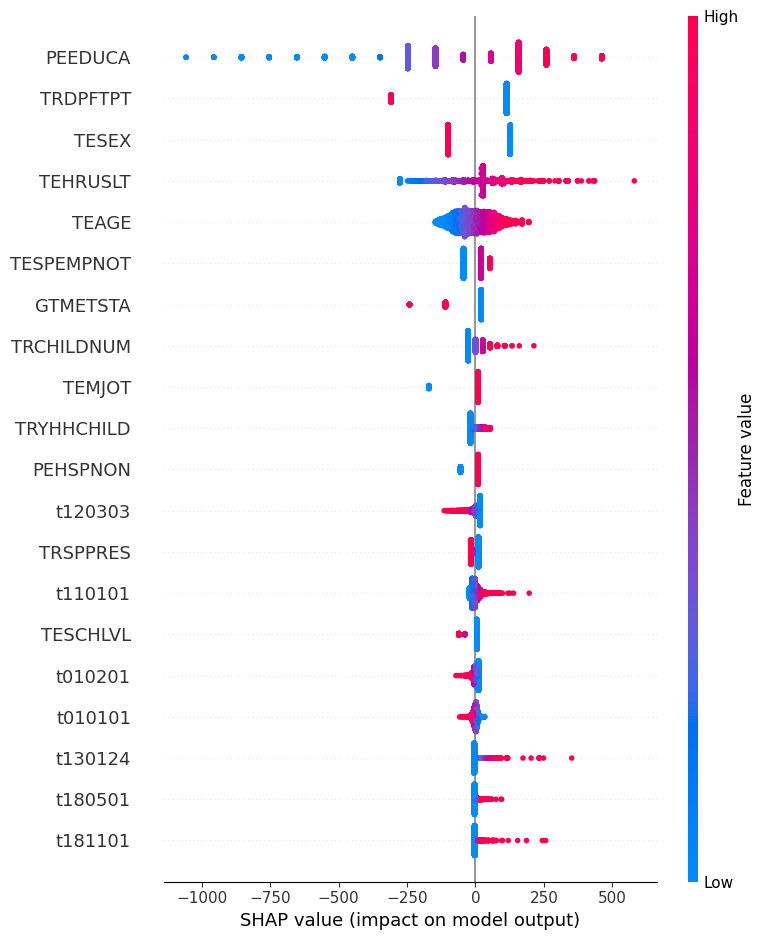

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Encoded

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.501e+06, tolerance: 7.528e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+06, tolerance: 7.534e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 431.6536728624669
R2 Score: 0.431135395501713
______

2022 MAE: 484.0650470430919
2022 R2 Score: 0.3601299337889622



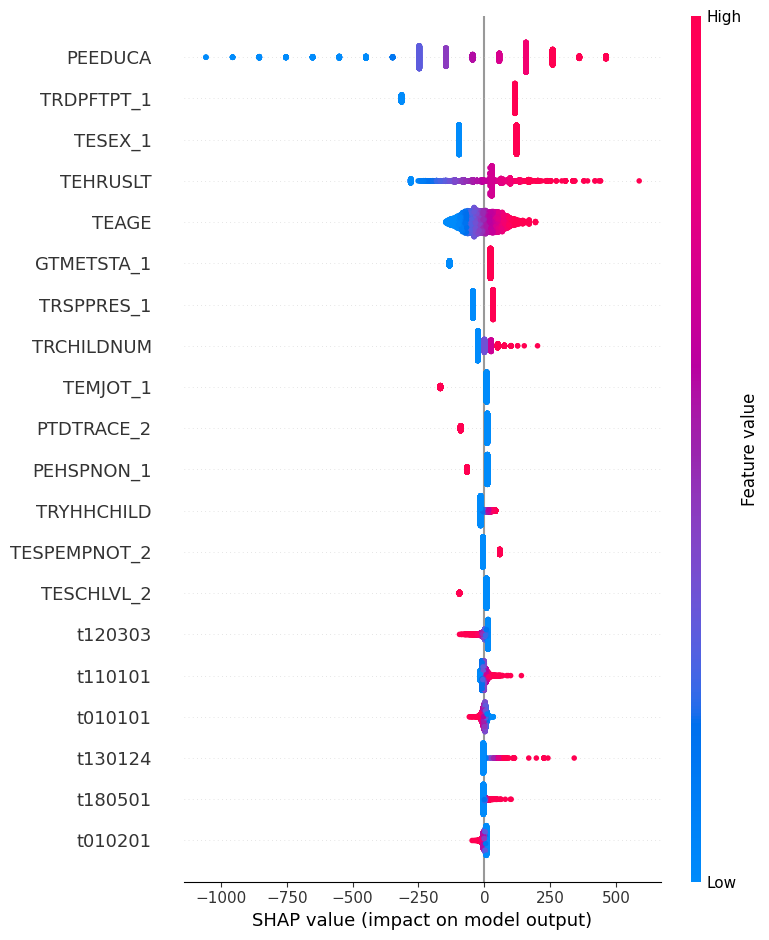

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA

In [15]:
lasso_model = Lasso()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_pca, y_train_pca)

y_pred = best_lasso_model.predict(X_test_pca)
y_pred2022 = best_lasso_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.794e+06, tolerance: 7.528e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.470e+06, tolerance: 7.534e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 451.7602651686343
R2 Score: 0.3798068882169695
______

2022 MAE: 504.9675685118194
2022 R2 Score: 0.2952380090299125



### Bayesian Ridge Regression


Test MAE: 438.4367495932809
R2 Score: 0.40634677117643325
______

2022 MAE: 498.29484960013406
2022 R2 Score: 0.008103054282045719



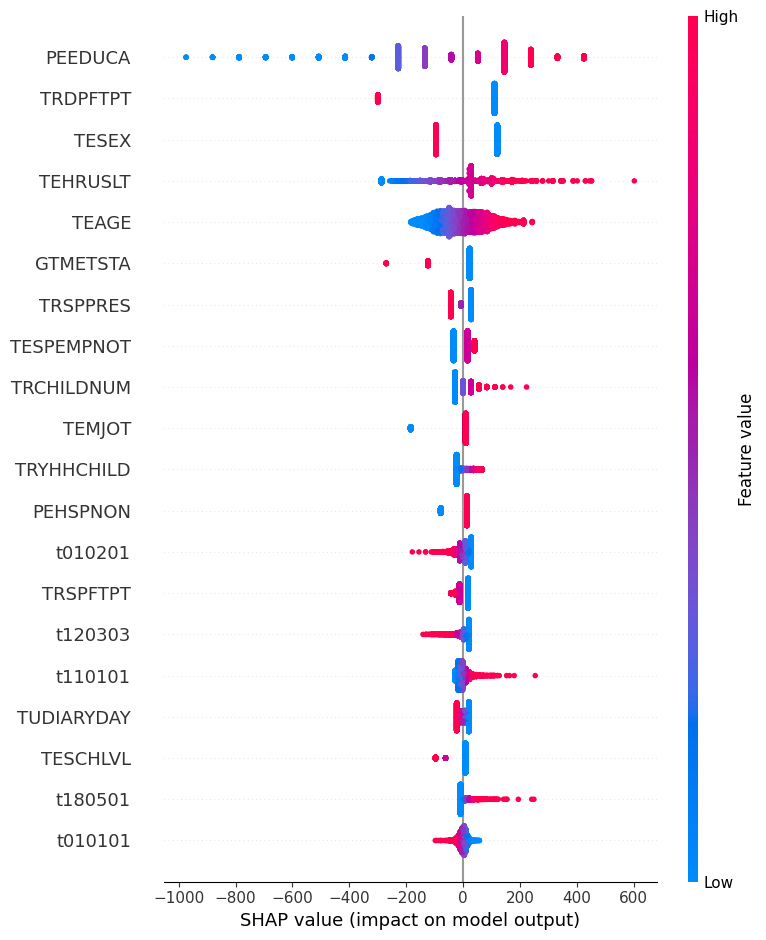

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()


Test MAE: 434.19781375652445
R2 Score: 0.41582281893029316
______

2022 MAE: 496.2097580613976
2022 R2 Score: 0.03411970217249127



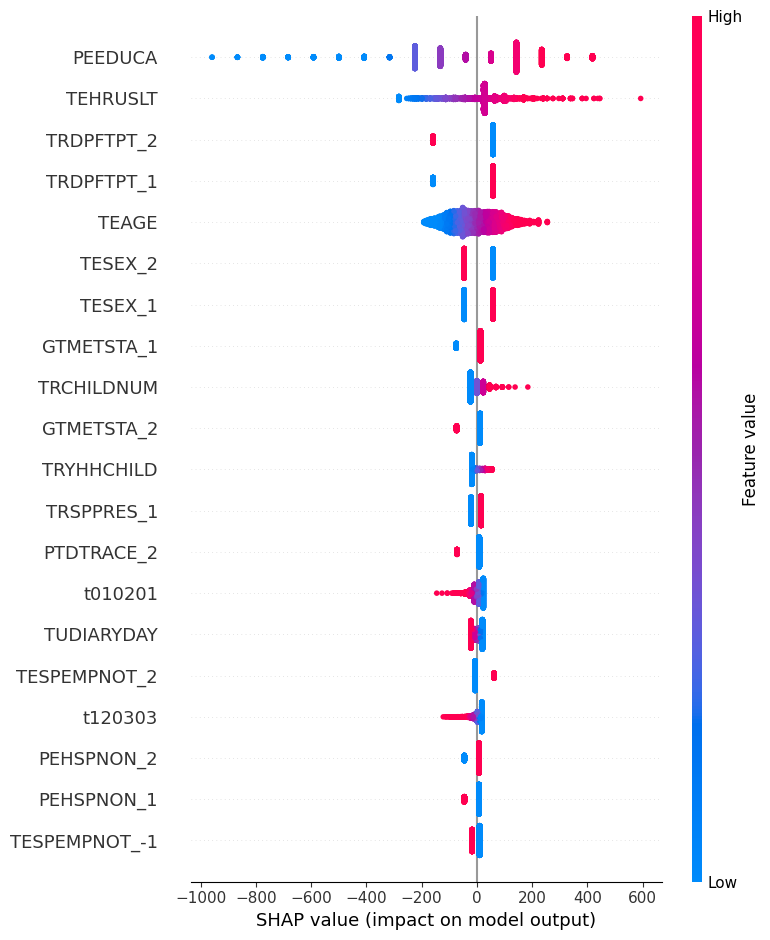

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)

plt.show()

##### PCA

In [13]:
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_pca, y_train_pca)

y_pred = bayesian_ridge_model.predict(X_test_pca)
y_pred2022 = bayesian_ridge_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 447.58069424494545
R2 Score: 0.37913220408066184
______

2022 MAE: 508.89351472040346
2022 R2 Score: 0.04062283174826975



## Machine Learning Modellen

### Decision Tree

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}

Test MAE: 405.1146552911013
R2 Score: 0.4502623375631548
______

2022 MAE: 457.4530313648495
2022 R2 Score: 0.3811679170250014



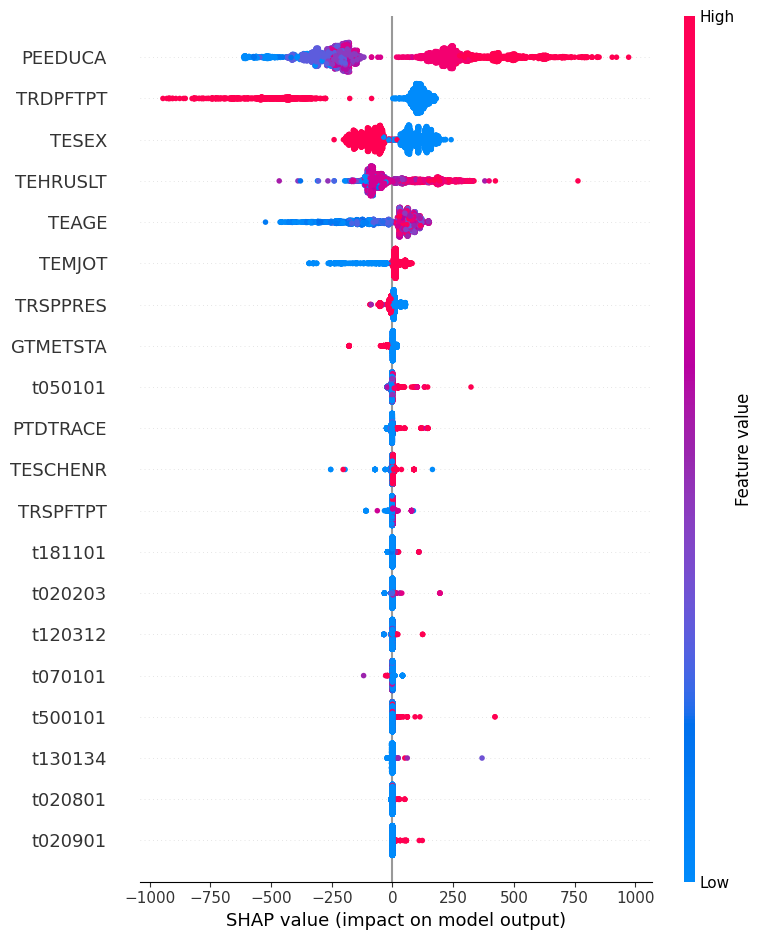

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Encoded

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}

Test MAE: 405.7151978277456
R2 Score: 0.44809293337505607
______

2022 MAE: 456.8346444181263
2022 R2 Score: 0.3819364189434521



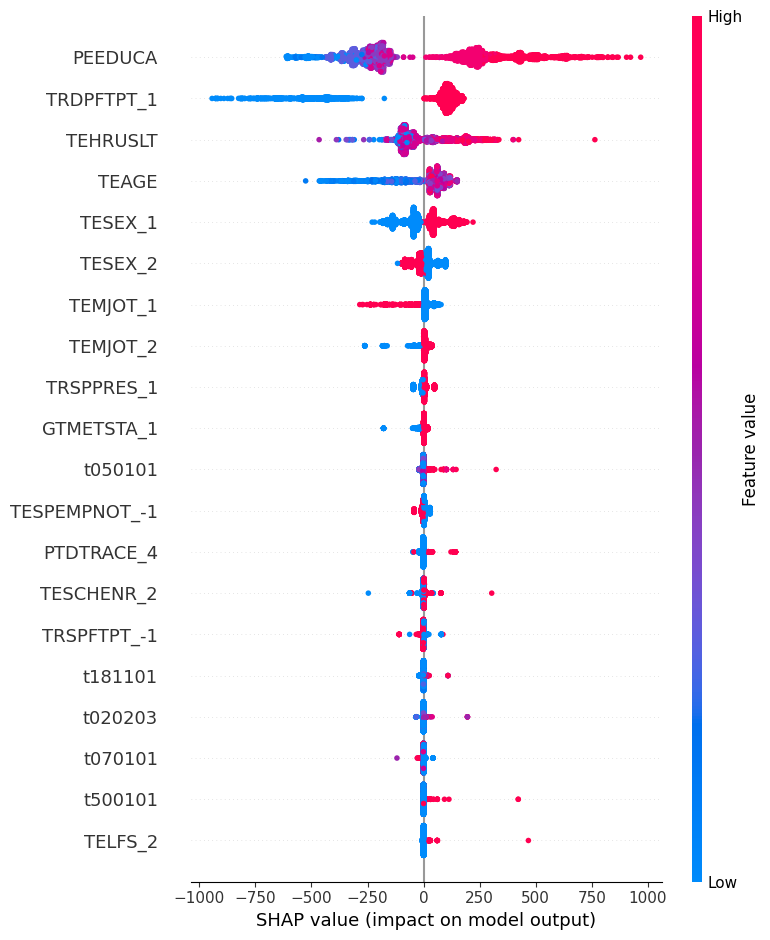

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)
plt.show()

##### PCA

In [16]:
tree_model = DecisionTreeRegressor()
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_pca, y_train_pca)

y_pred = best_tree_model.predict(X_test_pca)
y_pred2022 = best_tree_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}

Test MAE: 491.0621489067777
R2 Score: 0.2423932673134851
______

2022 MAE: 548.979266049012
2022 R2 Score: 0.16732513687143236



### Random Forests

Beste hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 387.19536287191454
R2 Score: 0.49687422146598215
______

2022 MAE: 442.3488475947389
2022 R2 Score: 0.41724312320531864



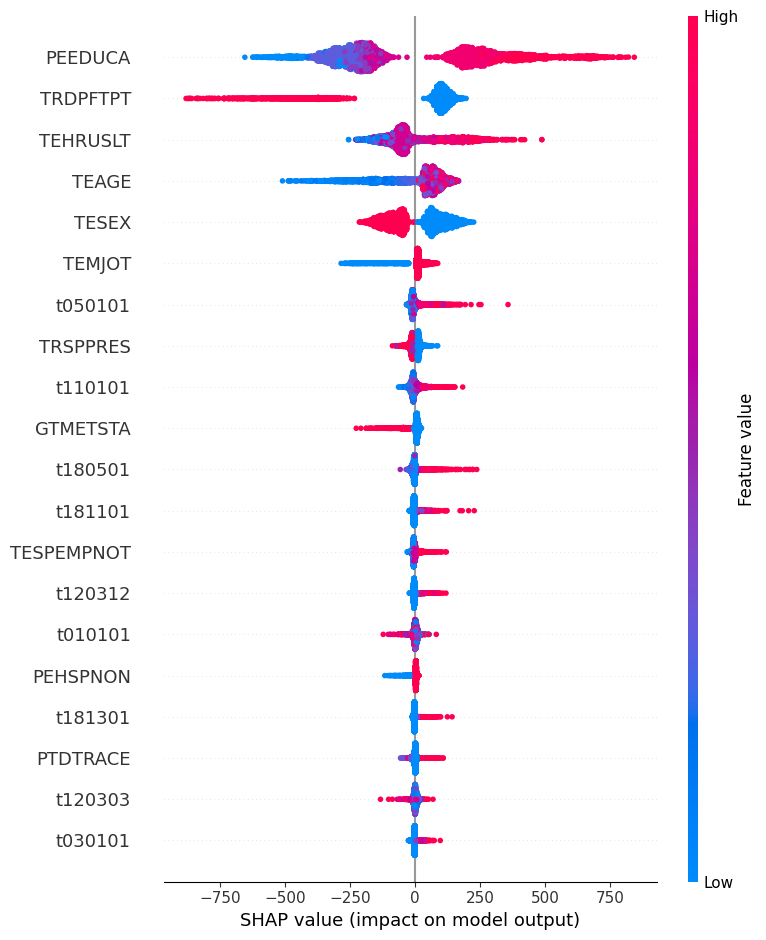

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Encoded

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 387.09785250461124
R2 Score: 0.4969989853202762
______

2022 MAE: 441.9738988043257
2022 R2 Score: 0.4179068677429453



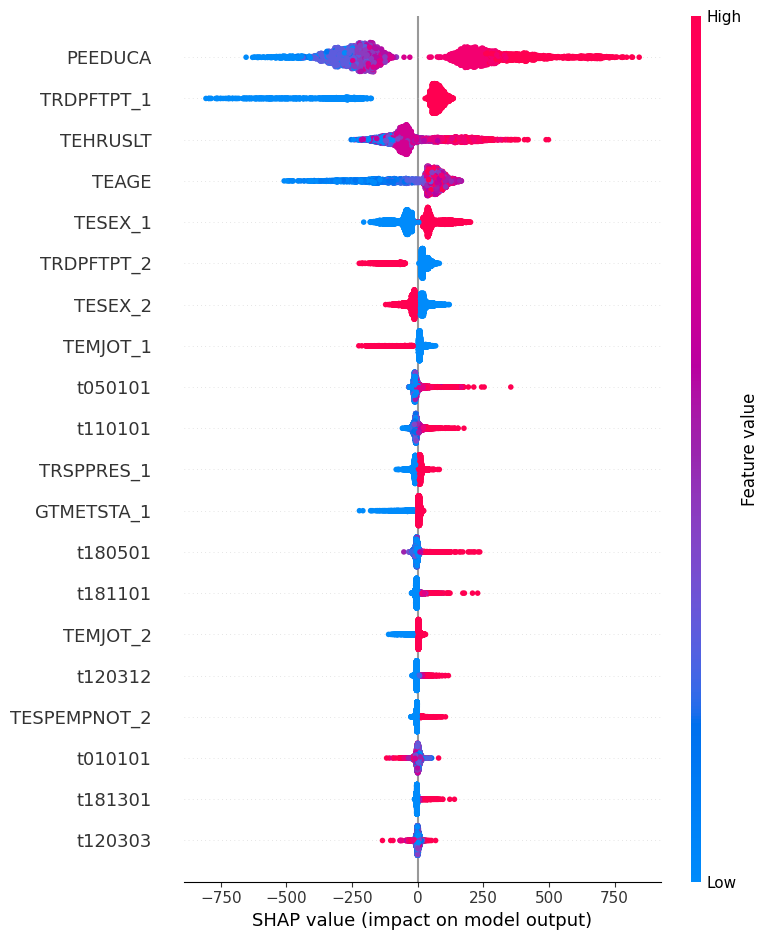

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)
plt.show()

##### PCA

In [11]:
rf_model = RandomForestRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_pca, y_train_pca)

y_pred = best_rf_model.predict(X_test_pca)
y_pred2022 = best_rf_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Test MAE: 456.87080862860506
R2 Score: 0.35317731375666117
______

2022 MAE: 508.18221389658186
2022 R2 Score: 0.27855120167217706



### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Test MAE: 386.32474129570284
R2 Score: 0.507806890624527
______

2022 MAE: 437.5019130108453
2022 R2 Score: 0.4344984714309069



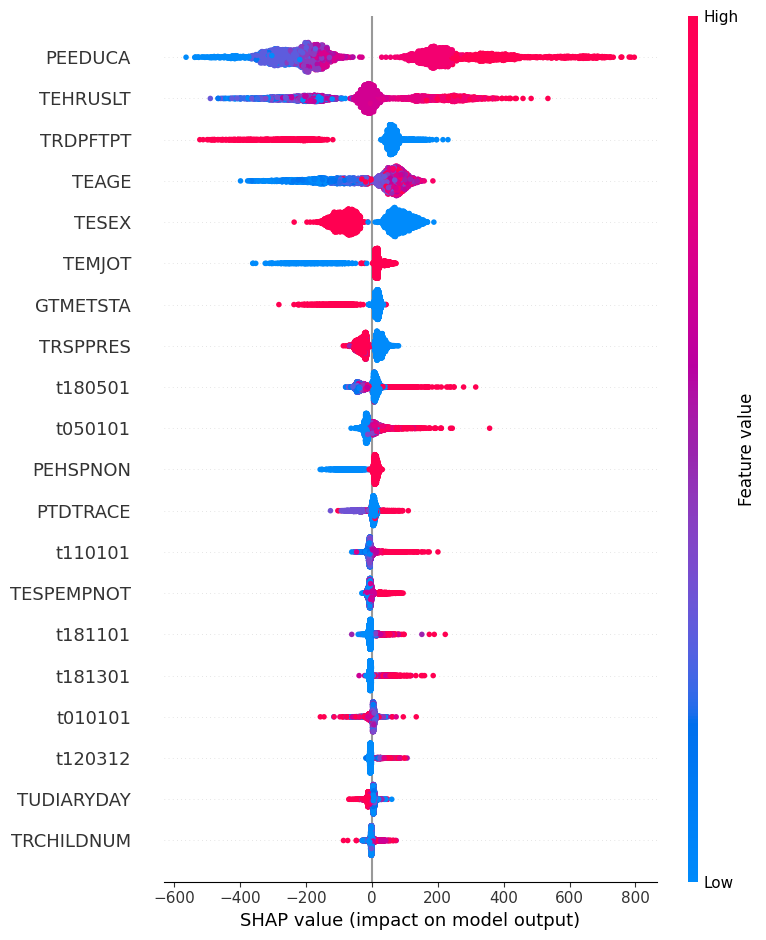

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Test MAE: 384.3898675997568
R2 Score: 0.512010736703193
______

2022 MAE: 437.7838804522677
2022 R2 Score: 0.43709887532876535



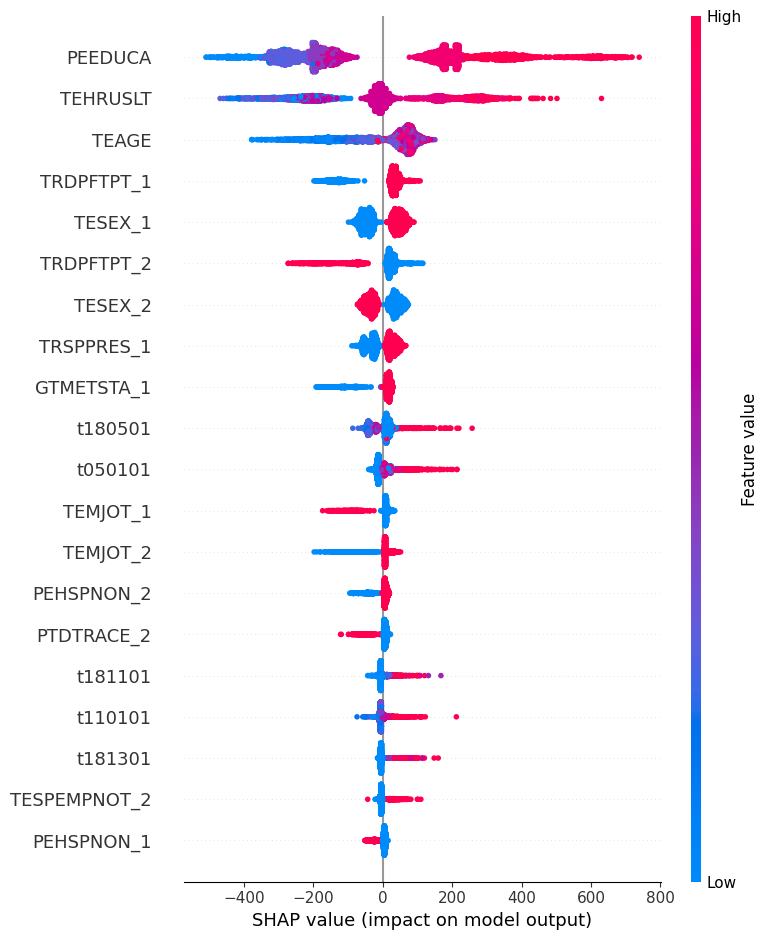

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train_encoded.columns)
plt.show()

##### PCA

In [11]:
gbr_model = GradientBoostingRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_pca, y_train_pca)

y_pred = best_gbr_model.predict(X_test_pca)
y_pred2022 = best_gbr_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Test MAE: 431.14322563576195
R2 Score: 0.4115895063298578
______

2022 MAE: 482.95905163093914
2022 R2 Score: 0.3375182854023926



### Support Vector Machines (SVM)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'sigmoid'}


SVR(C=100, kernel='sigmoid')


Test MAE: 429.59029042700274
R2 Score: 0.3671665764813583
______

2022 MAE: 519.7815658632651
2022 R2 Score: 0.20751693877896604



  0%|          | 0/100 [00:00<?, ?it/s]

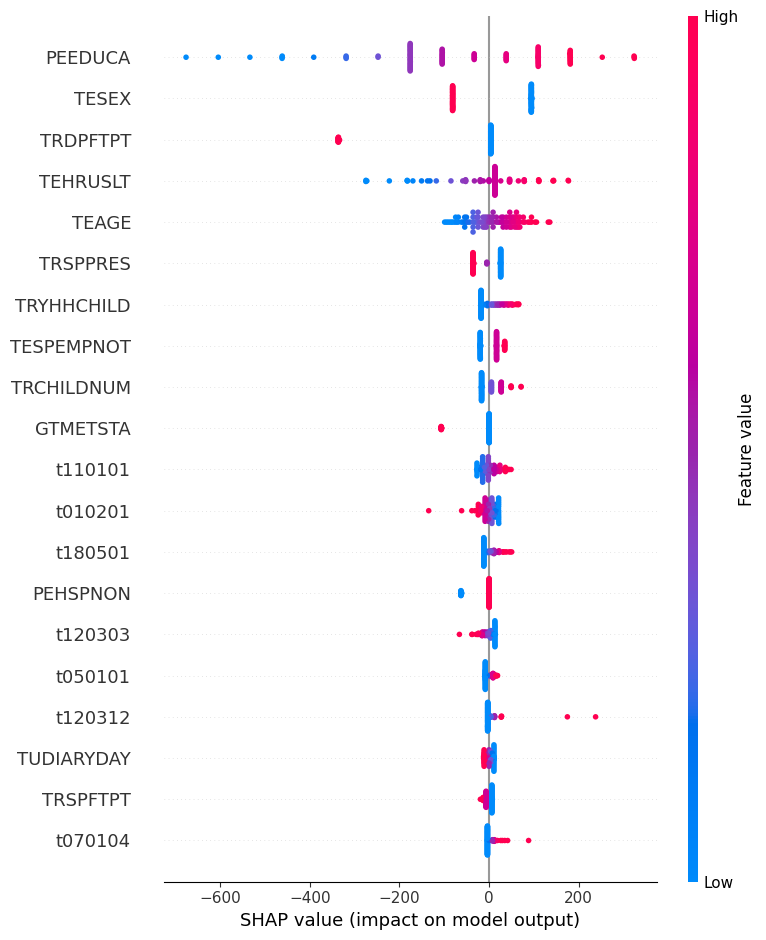

In [17]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

background = shap.kmeans(X_train_scaled, 50)  
subset_size = 100
X_test_scaled_subset, y_test_subset = shuffle(X_test_scaled, y_test, random_state=1, n_samples=subset_size)

explainer = shap.KernelExplainer(best_svr_model.predict, background)
shap_values_test = explainer.shap_values(X_test_scaled_subset)

shap.summary_plot(shap_values_test, X_test_scaled_subset, feature_names=X_train.columns)
plt.show()

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'sigmoid'}

Test MAE: 424.7378028171585
R2 Score: 0.37874433904784177
______

2022 MAE: 517.3914125054703
2022 R2 Score: 0.21612694101072594



##### PCA

In [12]:
svr_model = SVR()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_pca, y_train_pca)

y_pred = best_svr_model.predict(X_test_pca)
y_pred2022 = best_svr_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'C': 0.1, 'epsilon': 1, 'kernel': 'linear'}

Test MAE: 436.88031839644606
R2 Score: 0.3325275575330946
______

2022 MAE: 540.7561439644915
2022 R2 Score: -0.11716134992013938



### K-Nearest Neighbors (KNN)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}

Test MAE: 524.0756917393958
R2 Score: 0.19248059065214906
______

2022 MAE: 569.9321118406575
2022 R2 Score: 0.11989612575896536



In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X2022_scaled = scaler.transform(X_encoded2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

mae_2022 = mean_absolute_error(y_encoded2022, y_pred2022)
r2_2022 = r2_score(y_encoded2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}

Test MAE: 509.6359340719812
R2 Score: 0.2260155316368494
______

2022 MAE: 558.2505239048274
2022 R2 Score: 0.1488796707925163



##### PCA

In [13]:
knn_model = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_pca, y_train_pca)

y_pred = best_knn_model.predict(X_test_pca)
y_pred2022 = best_knn_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}

Test MAE: 514.3723222599551
R2 Score: 0.21585564936484447
______

2022 MAE: 562.248046962742
2022 R2 Score: 0.14497409744854528



## Deep Learning Modellen

Epoch 1/100


2024-07-30 22:47:14.970126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


428/428 [==============================] - 1s 2ms/step - loss: 1037255.8750 - mae: 760.9737 - val_loss: 446601.2188 - val_mae: 495.4168
Epoch 2/100
428/428 [==============================] - 1s 2ms/step - loss: 383828.8750 - mae: 460.5746 - val_loss: 386606.7500 - val_mae: 459.9883
Epoch 3/100
428/428 [==============================] - 1s 2ms/step - loss: 349081.5000 - mae: 439.0995 - val_loss: 372793.5938 - val_mae: 454.4653
Epoch 4/100
428/428 [==============================] - 1s 2ms/step - loss: 334871.6250 - mae: 430.2162 - val_loss: 362469.1875 - val_mae: 444.6436
Epoch 5/100
428/428 [==============================] - 1s 2ms/step - loss: 325314.4688 - mae: 423.4744 - val_loss: 358889.0312 - val_mae: 442.2255
Epoch 6/100
428/428 [==============================] - 1s 2ms/step - loss: 318389.6875 - mae: 418.3913 - val_loss: 355830.0625 - val_mae: 441.3001
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 313133.0312 - mae: 414.7775 - val_loss: 352655.5000 - 

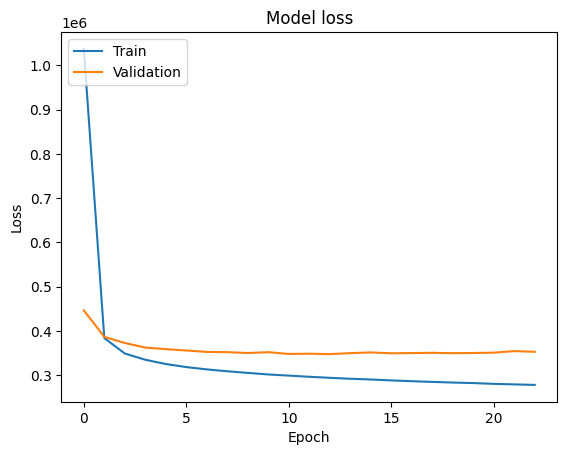

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [02:15, 29.61it/s]                       


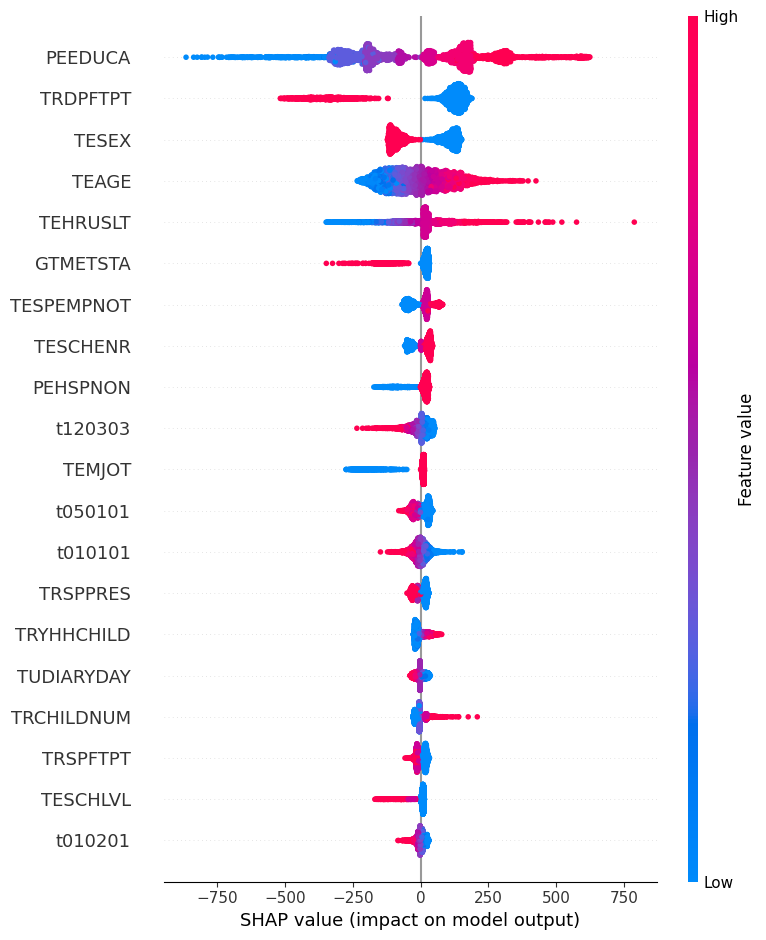

In [14]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Random Search

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10,  
    executions_per_trial=2,  
    directory='my_dir',
    project_name='income_prediction2'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Trial 10 Complete [00h 00m 37s]
val_mae: 423.9124298095703

Best val_mae So Far: 418.46649169921875
Total elapsed time: 00h 05m 45s
Epoch 1/50
214/214 [==============================] - 1s 2ms/step - loss: 872808.9375 - mae: 690.7032 - val_loss: 389008.8438 - val_mae: 460.0476
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 362273.7812 - mae: 445.5578 - val_loss: 366097.9062 - val_mae: 446.9079
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 337079.3750 - mae: 429.4743 - val_loss: 361634.3125 - val_mae: 437.7738
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 322962.1562 - mae: 420.1561 - val_loss: 359440.4062 - val_mae: 448.7399
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 313468.7188 - mae: 414.3834 - val_loss: 352751.2500 - val_mae: 437.7815
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 305810.4062 - mae: 409.1694 - val_loss: 349558.5000 - val_mae: 4

PermutationExplainer explainer: 4274it [02:25, 27.33it/s]                       


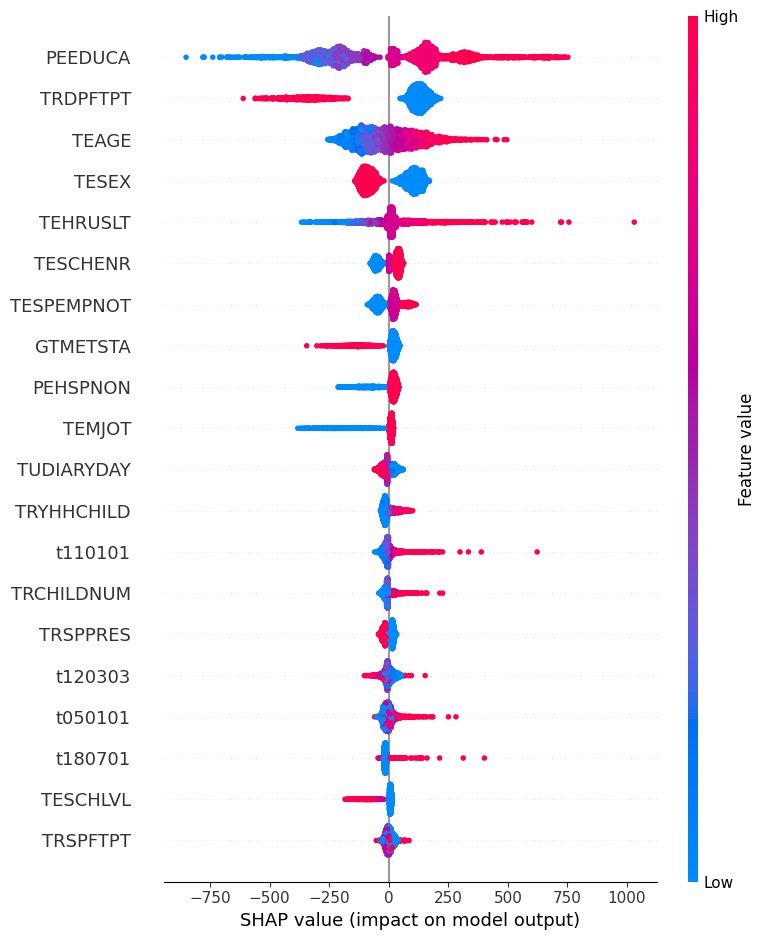

In [18]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-07-30 23:00:52,885] A new study created in memory with name: no-name-f556489f-da52-4b80-b834-7266454d43d0


134/134 [==============================] - 0s 717us/step


[I 2024-07-30 23:01:08,684] Trial 0 finished with value: 1017.1887553059072 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 2.639400982305608e-05}. Best is trial 0 with value: 1017.1887553059072.


134/134 [==============================] - 0s 614us/step


[I 2024-07-30 23:01:20,172] Trial 1 finished with value: 425.25277130962564 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004192215569928352}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 666us/step


[I 2024-07-30 23:01:32,386] Trial 2 finished with value: 845.7626819481862 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0011557324927183228}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 778us/step


[I 2024-07-30 23:01:38,174] Trial 3 finished with value: 426.69034639372353 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007067322839678645}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 879us/step


[I 2024-07-30 23:02:00,185] Trial 4 finished with value: 1022.1340429790591 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 1.0420375379751336e-05}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 726us/step


[I 2024-07-30 23:02:15,161] Trial 5 finished with value: 788.0475627941731 and parameters: {'num_layers': 1, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 7.391424362741633e-05}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 648us/step


[I 2024-07-30 23:02:30,394] Trial 6 finished with value: 622.6199680098933 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 1.730061325508779e-05}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 793us/step


[I 2024-07-30 23:02:47,204] Trial 7 finished with value: 439.38357345875664 and parameters: {'num_layers': 3, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00012382052523262293}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 754us/step


[I 2024-07-30 23:03:01,162] Trial 8 finished with value: 1039.0137990035034 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 1.3939104844717904e-05}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 23:03:20,248] Trial 9 finished with value: 1032.01457613259 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 1.6282925193526654e-05}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 797us/step


[I 2024-07-30 23:03:27,785] Trial 10 finished with value: 427.1810439673526 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.009561871145895484}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 924us/step


[I 2024-07-30 23:03:35,197] Trial 11 finished with value: 429.41582270176997 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009842819692697157}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 818us/step


[I 2024-07-30 23:03:52,784] Trial 12 finished with value: 441.8123788604718 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0015070932026220714}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 945us/step


[I 2024-07-30 23:04:00,359] Trial 13 finished with value: 426.74555035513237 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002775079949400301}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 930us/step


[I 2024-07-30 23:04:17,853] Trial 14 finished with value: 434.2943534350066 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0004847558564435875}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 863us/step


[I 2024-07-30 23:04:28,712] Trial 15 finished with value: 431.6741238009442 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0024890553683570406}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 896us/step


[I 2024-07-30 23:04:35,827] Trial 16 finished with value: 425.83516717147916 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0048083217559442525}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 731us/step


[I 2024-07-30 23:04:51,436] Trial 17 finished with value: 508.2606609051216 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0003703370501144603}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 857us/step


[I 2024-07-30 23:05:02,324] Trial 18 finished with value: 428.4580767393034 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004087994271382961}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 863us/step


[I 2024-07-30 23:05:16,681] Trial 19 finished with value: 430.65411701569315 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005847473590312171}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 786us/step


[I 2024-07-30 23:05:30,825] Trial 20 finished with value: 435.185041507263 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0010980023654738999}. Best is trial 1 with value: 425.25277130962564.


134/134 [==============================] - 0s 896us/step


[I 2024-07-30 23:05:38,179] Trial 21 finished with value: 425.0462402292328 and parameters: {'num_layers': 3, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005061833497736211}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 971us/step


[I 2024-07-30 23:05:44,974] Trial 22 finished with value: 435.80006405491815 and parameters: {'num_layers': 3, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005487065182463436}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 717us/step


[I 2024-07-30 23:05:51,717] Trial 23 finished with value: 425.46273090329515 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0027383324215977793}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 669us/step


[I 2024-07-30 23:05:59,216] Trial 24 finished with value: 428.78130679611974 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0024866171452509996}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 697us/step


[I 2024-07-30 23:06:08,510] Trial 25 finished with value: 431.87089895322066 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0017598032253277544}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 722us/step


[I 2024-07-30 23:06:28,684] Trial 26 finished with value: 813.1628159977373 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00019700133205729952}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 704us/step


[I 2024-07-30 23:06:41,960] Trial 27 finished with value: 431.44591372737443 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009756198707165342}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 640us/step


[I 2024-07-30 23:06:51,392] Trial 28 finished with value: 427.5737274801985 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.003618723632094761}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 725us/step


[I 2024-07-30 23:07:07,408] Trial 29 finished with value: 1000.2510476076606 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 4.8119890584515454e-05}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 657us/step


[I 2024-07-30 23:07:12,805] Trial 30 finished with value: 431.91797209300677 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005710261213491359}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 868us/step


[I 2024-07-30 23:07:18,873] Trial 31 finished with value: 425.2970823215562 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004454937080599802}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 739us/step


[I 2024-07-30 23:07:25,765] Trial 32 finished with value: 425.29934437886357 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0020176016224118494}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 731us/step


[I 2024-07-30 23:07:32,100] Trial 33 finished with value: 428.5229131707268 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001695042353739348}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 763us/step


[I 2024-07-30 23:07:48,786] Trial 34 finished with value: 622.872513259836 and parameters: {'num_layers': 3, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0007760332249734925}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 467us/step


[I 2024-07-30 23:07:54,194] Trial 35 finished with value: 430.3749246410082 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.007352984580445227}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 658us/step


[I 2024-07-30 23:08:02,350] Trial 36 finished with value: 426.01815509006065 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0036376993012184893}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 786us/step


[I 2024-07-30 23:08:10,099] Trial 37 finished with value: 425.1584404582696 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006662658952601109}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 23:08:23,435] Trial 38 finished with value: 458.4962893505887 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00724768172783811}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 789us/step


[I 2024-07-30 23:08:39,209] Trial 39 finished with value: 429.1973919888422 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.006455060531973514}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 769us/step


[I 2024-07-30 23:08:57,368] Trial 40 finished with value: 436.5341109815348 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00020777344744347124}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 820us/step


[I 2024-07-30 23:09:06,804] Trial 41 finished with value: 433.8091093480177 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0037030493113756322}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 938us/step


[I 2024-07-30 23:09:13,577] Trial 42 finished with value: 426.2648728248316 and parameters: {'num_layers': 3, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0019972879339875986}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 851us/step


[I 2024-07-30 23:09:20,582] Trial 43 finished with value: 430.4451303480538 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009197479017414174}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 681us/step


[I 2024-07-30 23:09:30,172] Trial 44 finished with value: 433.07855343994316 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0013585568989422311}. Best is trial 21 with value: 425.0462402292328.


134/134 [==============================] - 0s 917us/step


[I 2024-07-30 23:09:36,173] Trial 45 finished with value: 423.6809915837477 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004572824309232945}. Best is trial 45 with value: 423.6809915837477.


134/134 [==============================] - 0s 459us/step


[I 2024-07-30 23:09:49,662] Trial 46 finished with value: 573.84190095044 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0042883144269654574}. Best is trial 45 with value: 423.6809915837477.


134/134 [==============================] - 0s 969us/step


[I 2024-07-30 23:10:00,383] Trial 47 finished with value: 423.73169881751494 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00988838945725335}. Best is trial 45 with value: 423.6809915837477.


134/134 [==============================] - 0s 907us/step


[I 2024-07-30 23:10:11,938] Trial 48 finished with value: 420.2962551334952 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.007723408571437867}. Best is trial 48 with value: 420.2962551334952.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 23:10:21,509] Trial 49 finished with value: 428.59385348165785 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009615562439452012}. Best is trial 48 with value: 420.2962551334952.


FrozenTrial(number=48, state=TrialState.COMPLETE, values=[420.2962551334952], datetime_start=datetime.datetime(2024, 7, 30, 23, 10, 0, 384184), datetime_complete=datetime.datetime(2024, 7, 30, 23, 10, 11, 938161), params={'num_layers': 2, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.007723408571437867}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=48, value=None)
133/133 [==============================] - 0s 971us/step


Test MAE: 429.39940983517624
R2 Score: 0.38082754139126695

______
2022 MAE: 484.20847072220397
2022 R2 Score: 0.30140549108824977


PermutationExplainer explainer: 4274it [02:11, 29.92it/s]                       


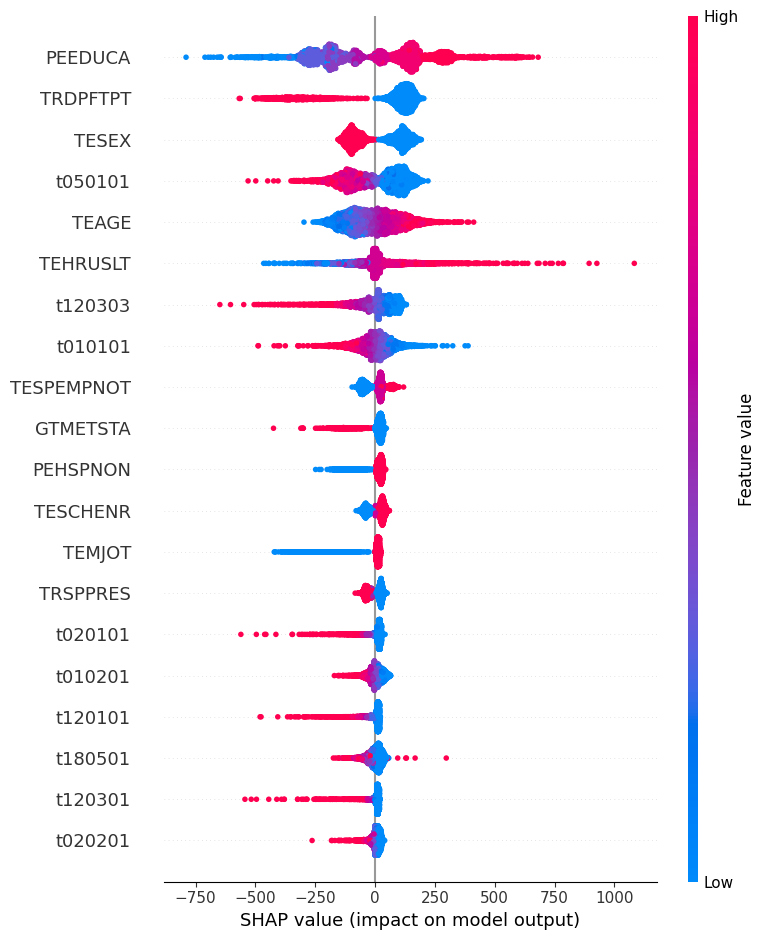

In [20]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

### 1D Convolutional Neural Network

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 4s 9ms/step - loss: 681663.6875 - mae: 637.2985 - val_loss: 522447.4688 - val_mae: 567.1017
Epoch 2/100
428/428 [==============================] - 3s 8ms/step - loss: 500467.0000 - mae: 559.4268 - val_loss: 447609.6562 - val_mae: 523.5881
Epoch 3/100
428/428 [==============================] - 4s 8ms/step - loss: 412617.0312 - mae: 499.9426 - val_loss: 385987.6250 - val_mae: 473.5222
Epoch 4/100
428/428 [==============================] - 4s 9ms/step - loss: 372311.4688 - mae: 470.3908 - val_loss: 372456.6562 - val_mae: 468.0629
Epoch 5/100
428/428 [==============================] - 4s 8ms/step - loss: 358695.8438 - mae: 459.9289 - val_loss: 370080.6250 - val_mae: 473.6135
Epoch 6/100
428/428 [==============================] - 3s 8ms/step - loss: 347785.7188 - mae: 450.2802 - val_loss: 364056.1875 - val_mae: 442.5518
Epoch 7/100
428/428 [==============================] - 4s 9ms/step - loss: 339173.8438 - mae: 441.0154 - val_loss: 356

In [22]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-07-30 23:14:37,154] A new study created in memory with name: no-name-06ef686f-464d-4741-a893-610d7a8506ab


134/134 [==============================] - 2s 17ms/step


[I 2024-07-30 23:22:54,599] Trial 0 finished with value: 592.6781573970552 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.3840156187723162, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.009883122607188516}. Best is trial 0 with value: 592.6781573970552.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:26:22,196] Trial 1 finished with value: 575.4806865402354 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.3824428383754244, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0009687348182936026}. Best is trial 1 with value: 575.4806865402354.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 23:31:01,773] Trial 2 finished with value: 491.8191629464337 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3852729670397801, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 4.5369479370743864e-05}. Best is trial 2 with value: 491.8191629464337.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 23:32:14,418] Trial 3 finished with value: 398.81961510109903 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.026215749492813134, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.005092960337283373}. Best is trial 3 with value: 398.81961510109903.


134/134 [==============================] - 2s 13ms/step


[I 2024-07-30 23:45:20,199] Trial 4 finished with value: 762.1082768685528 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.43214654247843187, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.0003046855207697156}. Best is trial 3 with value: 398.81961510109903.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:50:59,353] Trial 5 finished with value: 600.1766717166486 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.2592501406239849, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.00024023407158894701}. Best is trial 3 with value: 398.81961510109903.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-31 00:01:52,373] Trial 6 finished with value: 1017.5365348943938 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.09360158282400044, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 1.213371415565705e-05}. Best is trial 3 with value: 398.81961510109903.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 00:03:38,493] Trial 7 finished with value: 411.27041109200695 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3541557326334601, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0007360888308072949}. Best is trial 3 with value: 398.81961510109903.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-31 00:10:46,881] Trial 8 finished with value: 393.95039633212366 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.21070370119247883, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0005354536973139668}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 00:15:09,205] Trial 9 finished with value: 422.3677508808817 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1315496717449789, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.00020545227337918147}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-31 00:19:56,274] Trial 10 finished with value: 398.4406684632048 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.21606772762222734, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0020028029950310924}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 00:24:12,126] Trial 11 finished with value: 395.67868004726796 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.22858783141036249, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.002329336073234276}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 00:29:01,937] Trial 12 finished with value: 395.3668928271436 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2558904015107493, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.002240144666217979}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 00:31:59,635] Trial 13 finished with value: 478.1565084777268 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.28261195761931457, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 6.075117949218247e-05}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 00:37:41,125] Trial 14 finished with value: 403.53640667495534 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.17353481260081155, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0007602835695263567}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-31 00:41:07,324] Trial 15 finished with value: 398.83240752754796 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3022183832345312, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0026736957194896434}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 00:45:14,083] Trial 16 finished with value: 470.15488648807866 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1690699349768378, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 7.824176754471743e-05}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 00:45:45,858] Trial 17 finished with value: 405.7844579675729 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06796269330515853, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0011649848212203244}. Best is trial 8 with value: 393.95039633212366.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 00:49:30,042] Trial 18 finished with value: 389.17218449758866 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3185257499996408, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.005117885766544873}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 00:53:44,790] Trial 19 finished with value: 393.4237178703976 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4785293745848074, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00791169908012998}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 00:57:40,023] Trial 20 finished with value: 397.66764007745456 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4928647958522038, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.009999443440648572}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-31 01:01:13,010] Trial 21 finished with value: 406.26647226788475 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.487236272852674, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.005122384719937395}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-31 01:05:16,429] Trial 22 finished with value: 412.0655832768893 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.32688909278516365, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.005127146147643982}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-31 01:10:15,147] Trial 23 finished with value: 410.13895912315036 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.42403736974355716, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0005032876433263068}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 01:14:25,499] Trial 24 finished with value: 408.32131136152464 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.1917939462927461, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00011534045418154089}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 01:23:21,494] Trial 25 finished with value: 487.2211686318626 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4426462658097165, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 2.2500141863786548e-05}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 2s 12ms/step


[I 2024-07-31 01:28:48,555] Trial 26 finished with value: 592.8975863685313 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.3147720233447782, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.003990437278293848}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 01:30:08,581] Trial 27 finished with value: 402.04191206960206 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.1309438857184567, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00166482226001663}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 01:33:29,387] Trial 28 finished with value: 413.9789930280511 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3553432782671231, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0004551910442242345}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 01:37:07,462] Trial 29 finished with value: 592.9435877564705 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.4635013857341993, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.007266266997514909}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 01:38:23,199] Trial 30 finished with value: 418.6932348242711 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.21509981453922591, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0034332851176843183}. Best is trial 18 with value: 389.17218449758866.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 01:41:35,040] Trial 31 finished with value: 387.9830514217813 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2618836867494307, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.007091935845254754}. Best is trial 31 with value: 387.9830514217813.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 01:43:04,934] Trial 32 finished with value: 393.5055677287975 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.27049156809964725, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.007695269135890093}. Best is trial 31 with value: 387.9830514217813.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 01:44:59,932] Trial 33 finished with value: 395.91568605359817 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.39841274842473456, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.007346630189707893}. Best is trial 31 with value: 387.9830514217813.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 01:46:41,636] Trial 34 finished with value: 386.49394114427594 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2853140310967494, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.007594896288727574}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 01:48:48,977] Trial 35 finished with value: 409.16475907696906 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.3487208549980681, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.003596760137598711}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-31 01:52:38,629] Trial 36 finished with value: 391.91279317394736 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.29632090385803117, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012839571155142848}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 8ms/step


[I 2024-07-31 02:00:19,349] Trial 37 finished with value: 592.1659325109151 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.29211263687157785, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012851357944862337}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:01:55,417] Trial 38 finished with value: 392.65008624939907 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3311363977709367, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0054411494574703395}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 8ms/step


[I 2024-07-31 02:07:42,681] Trial 39 finished with value: 393.9909081820741 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.38867277557335345, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0014877574822145193}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:11:02,060] Trial 40 finished with value: 592.4743590820084 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.2414616788438862, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0029813359060217996}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 02:13:22,362] Trial 41 finished with value: 394.6867738348635 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3360812333632902, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.00475071506479407}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:15:39,505] Trial 42 finished with value: 387.2145035895346 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3662184499190696, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.00590643155639177}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 02:16:57,095] Trial 43 finished with value: 391.76852343255064 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.37342911076315083, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.006539396619243449}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 02:18:43,948] Trial 44 finished with value: 408.06616041296405 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.3689283521583091, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.009736830133348445}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-31 02:19:27,424] Trial 45 finished with value: 405.33216772771567 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4093679853536962, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.006202622365516157}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 02:21:55,112] Trial 46 finished with value: 395.04996285653243 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.37467019112292466, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.003916250681990707}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 02:23:29,963] Trial 47 finished with value: 402.64001883948487 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.27185803844608497, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.002096925486458009}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 02:24:40,526] Trial 48 finished with value: 386.73903670474124 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.31232436920268397, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.009666647230462108}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:26:39,888] Trial 49 finished with value: 402.4029169464379 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.23265031401450986, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.009482399887636177}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 946us/step


[I 2024-07-31 02:27:06,494] Trial 50 finished with value: 399.49515921977184 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2550712655432171, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.003036566653325492}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 02:28:00,495] Trial 51 finished with value: 393.7855570455538 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.31091782654602906, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.005821160548283311}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 02:29:03,305] Trial 52 finished with value: 401.07247320244136 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.35666147882231714, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.00434070903594014}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:30:42,972] Trial 53 finished with value: 391.9395725213865 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.31909071812148093, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0066366303287414075}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-31 02:31:36,536] Trial 54 finished with value: 401.6734456944661 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.2794238172395462, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002716805341534367}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 02:32:55,892] Trial 55 finished with value: 391.12087398659395 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3719070378816391, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.008535294100831087}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 02:33:57,932] Trial 56 finished with value: 409.28895014083844 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3410452941965525, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.009773545361964089}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-31 02:37:31,047] Trial 57 finished with value: 405.53544662707696 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.41840139646782626, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.004591225601546169}. Best is trial 34 with value: 386.49394114427594.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:39:14,269] Trial 58 finished with value: 385.4198307940867 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.018083146752389867, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.008109149567091786}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:41:36,790] Trial 59 finished with value: 592.8010973141218 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.09468298159989698, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0058893969124676655}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-31 02:44:35,178] Trial 60 finished with value: 410.7569794657123 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.014255559869312002, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007954831647925616}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-31 02:47:19,861] Trial 61 finished with value: 400.22566736937745 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.29846692893820004, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.008184305430511445}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-31 02:50:14,324] Trial 62 finished with value: 422.4247570235857 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.25685956173877805, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.00017679269460249214}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 02:51:08,913] Trial 63 finished with value: 393.0878720600745 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.03816273771570433, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0076866452746236335}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 02:52:22,317] Trial 64 finished with value: 394.3124474061961 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.1987886448435356, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.004812990483673638}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 02:54:02,711] Trial 65 finished with value: 394.4246853057222 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.43703583433777793, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.008519440197093714}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 02:55:36,677] Trial 66 finished with value: 395.5643140153955 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.16784095901813983, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.006133263546546958}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 2s 13ms/step


[I 2024-07-31 03:08:18,548] Trial 67 finished with value: 498.24807080535885 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3181435199489506, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 2.4871628074486408e-05}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 03:10:47,974] Trial 68 finished with value: 395.187883323505 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3961979100486291, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0035312698532161046}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 03:11:45,482] Trial 69 finished with value: 424.223266841318 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.35866080412593093, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0024354003016399785}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 03:13:30,927] Trial 70 finished with value: 590.2212293637466 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.28552656175609653, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.0019212538048815106}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 03:14:13,406] Trial 71 finished with value: 397.6852129617431 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.36726923137604817, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.006600568020405495}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 03:15:10,169] Trial 72 finished with value: 396.29727272465783 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.34210198270931796, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.007517381842901463}. Best is trial 58 with value: 385.4198307940867.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 03:16:23,142] Trial 73 finished with value: 382.6248465109374 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.37939933348416327, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.009972554386871738}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 03:17:21,944] Trial 74 finished with value: 398.98772536726153 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3845873713514635, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.008708496919782609}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 03:19:33,784] Trial 75 finished with value: 385.7847362511169 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.30625371484196573, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.005020075519946551}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 03:21:23,823] Trial 76 finished with value: 393.7401884766303 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3244552654489825, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.005259490595105694}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 03:23:53,200] Trial 77 finished with value: 386.9797242568623 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.270279907582448, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004189286939588723}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 03:26:11,312] Trial 78 finished with value: 398.00604588518206 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.24268365673079165, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004189851764836197}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-31 03:26:55,973] Trial 79 finished with value: 401.941141800797 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.26950448756545603, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0031897841269160746}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 03:28:53,785] Trial 80 finished with value: 408.89151041492875 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3012198433921718, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.005332908799359328}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-31 03:31:27,252] Trial 81 finished with value: 391.2809347119902 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.22700451627406673, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.006986164451101786}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-31 03:34:49,591] Trial 82 finished with value: 391.046171488623 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.31065644784394153, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0038455187636430212}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 03:36:55,648] Trial 83 finished with value: 389.5061140912856 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2767762004867635, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.004523749909313401}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 03:38:43,668] Trial 84 finished with value: 400.4374325031245 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2885639093385253, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.009861403098815957}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-31 03:42:37,905] Trial 85 finished with value: 405.685781550962 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2644730117245493, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.005753605521246975}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-31 03:45:27,056] Trial 86 finished with value: 592.9133948230989 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.24696530484319698, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.007108408642413896}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 03:48:04,014] Trial 87 finished with value: 566.9701853263315 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.33108461242889403, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 1.0277789761862092e-05}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 03:50:08,405] Trial 88 finished with value: 392.10616642371235 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3001350886999378, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.008278649693759748}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 03:53:05,415] Trial 89 finished with value: 402.94529977075786 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3497735308710706, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.00034935623378011375}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 03:55:48,483] Trial 90 finished with value: 392.3891445725377 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.22692312685458613, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.002506690361488103}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 03:58:11,363] Trial 91 finished with value: 395.6412759202854 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2838407124146029, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.004267919713664642}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 04:00:16,970] Trial 92 finished with value: 390.12165726132963 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2757552445053806, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.004973670877813576}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 04:02:34,907] Trial 93 finished with value: 402.81154758481046 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2609457504134477, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0036134494426884075}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-31 04:04:44,307] Trial 94 finished with value: 390.94656054899616 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3073809387790409, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.00629235330687518}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-31 04:06:05,110] Trial 95 finished with value: 393.4252126731043 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.32261594929991383, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.004572938185901281}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-31 04:08:04,899] Trial 96 finished with value: 396.1498232434147 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.20162443458984394, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0028250793213782563}. Best is trial 73 with value: 382.6248465109374.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-31 04:12:18,034] Trial 97 finished with value: 382.0413904078615 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4066287494763312, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.005568334517679239}. Best is trial 97 with value: 382.0413904078615.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-31 04:16:47,736] Trial 98 finished with value: 391.58124319017173 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.4129493812914627, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.008432797260639703}. Best is trial 97 with value: 382.0413904078615.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-31 04:21:19,390] Trial 99 finished with value: 592.8035114666675 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.44473374262382703, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.009789374492539622}. Best is trial 97 with value: 382.0413904078615.


FrozenTrial(number=97, state=TrialState.COMPLETE, values=[382.0413904078615], datetime_start=datetime.datetime(2024, 7, 31, 4, 8, 4, 900169), datetime_complete=datetime.datetime(2024, 7, 31, 4, 12, 18, 33628), params={'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4066287494763312, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.005568334517679239}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution

In [23]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 1s 9ms/step


Test MAE: 399.68301955924784
R2 Score: 0.4848752777678743

______
2022 MAE: 455.9818100026746
2022 R2 Score: 0.3375152301323334


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


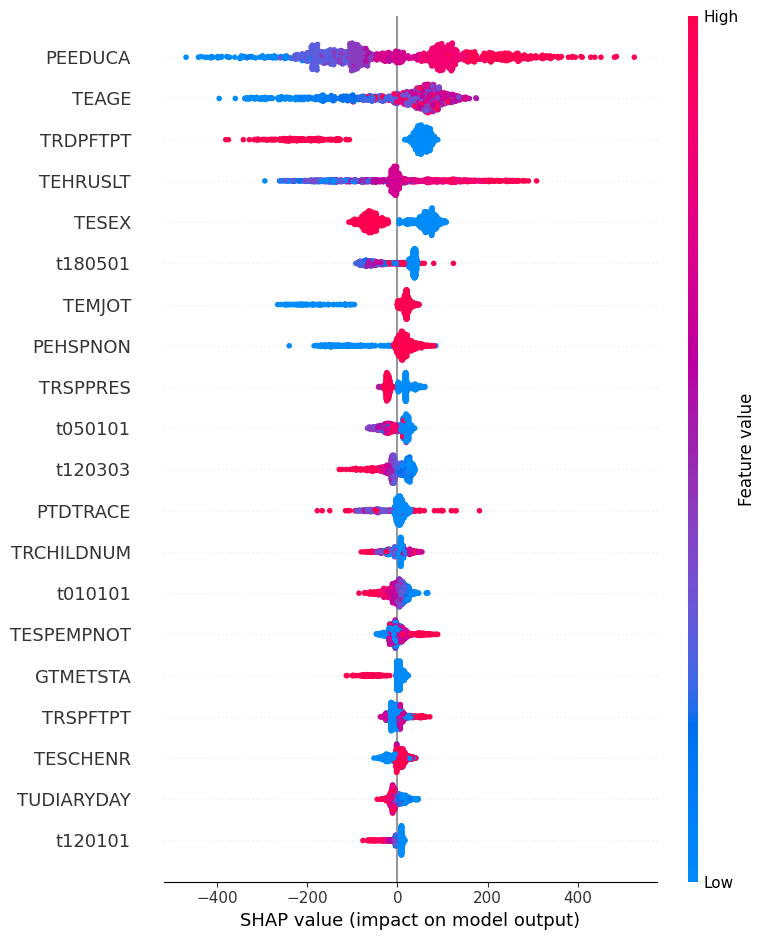

In [24]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(best_model, background)

X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)